<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Visualization</div>

In [1]:
import sys, os

In [2]:
sys.path.append(os.path.abspath('../autoencoders'))

In [3]:
# "Magic" commands for automatic reloading of module, perfect for prototyping
%reload_ext autoreload
%autoreload 2

import wasserstein
import proteins
import visualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [6]:
import numpy as np
import pandas as pd

import torch

In [7]:
from tqdm import tqdm

In [8]:
from scipy.stats import spearmanr

# Paths

In [9]:
ROOT = '../'

In [10]:
MODULE_PATH = ROOT + 'autoencoders/'
DATA_PATH = ROOT + 'data/'
NOTEBOOK_PATH = ROOT + 'notebooks/'
MODELS_PATH = ROOT + 'models/'
GRAPHICS_PATH = ROOT + 'graphics/'

# Loading the model

In [16]:
model = proteins.WassersteinAutoEncoder(ksi=10., hidden_dimension=10)
model.load_state_dict(torch.load(MODELS_PATH + 'wae-h=10.weights', map_location='cpu'))

In [11]:
model2 = proteins.WassersteinAutoEncoder(ksi=10., hidden_dimension=2)
model2.load_state_dict(torch.load(MODELS_PATH + 'wae.weights', map_location='cpu'))

# Dataset

In [12]:
complete_set = np.load(DATA_PATH + 'pgm-dataset.npy')

In [40]:
test_set = np.load(DATA_PATH + 'test-data.npy')
test_fitness = np.load(DATA_PATH + 'test-fitness.npy')

In [14]:
prot = visualization.Protein(complete_set[0])

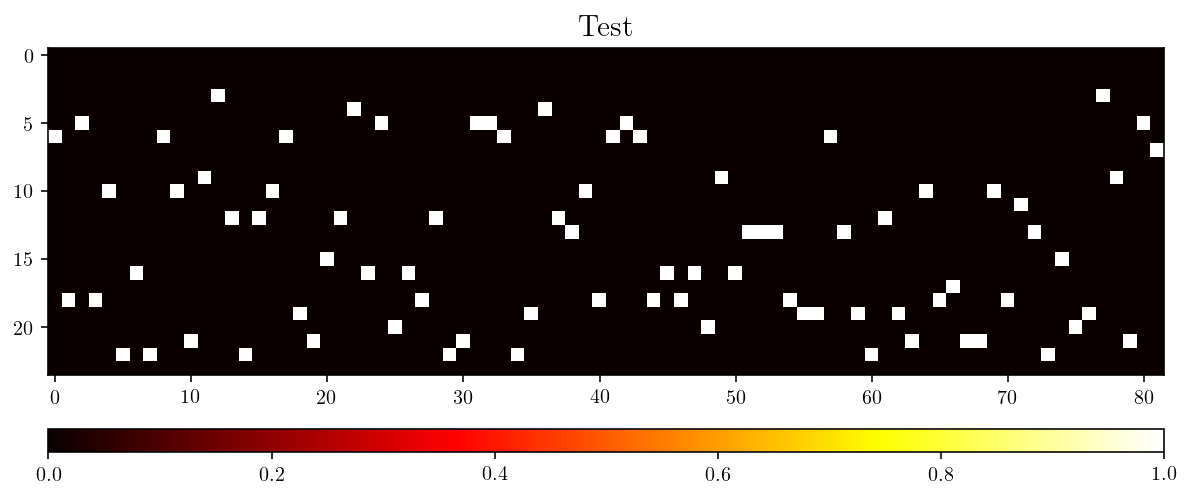

In [14]:
prot.plot_sequence(title='Test', save=GRAPHICS_PATH+'test-visualization.pdf')

Let us look at the accuracy (number of letters predicted right) and the log-probability of the sequence as output by the network. To that end, we added a `log_softmax()` method in order to use the eponymous stable loss function from `PyTorch`.

In [36]:
with torch.no_grad():
    log_reconstruction = model.log_softmax(torch.Tensor(complete_set))
    reconstruction, _ = model.forward(torch.Tensor(complete_set))

In [37]:
with torch.no_grad():
    log_reconstruction2 = model2.log_softmax(torch.Tensor(complete_set))
    reconstruction2, _ = model2.forward(torch.Tensor(complete_set))

In [38]:
reconstruction = np.array(reconstruction)
log_reconstruction = np.array(log_reconstruction)

In [39]:
reconstruction2 = np.array(reconstruction2)
log_reconstruction2 = np.array(log_reconstruction2)

# Accuracy of the reconstructions

In [70]:
accuracy = pd.DataFrame(columns=[2, 10], index=np.arange(len(complete_set)), dtype=float)

iterator = tqdm(
    enumerate(zip(
        reconstruction.reshape(-1, 24, 82), 
        complete_set.reshape(-1, 24, 82), 
        reconstruction2.reshape(-1, 24, 82)
    )), 
    ascii=True, 
    ncols=100,
    total=len(complete_set)
)

for i, (r, p, r2) in iterator:
    
    accuracy.loc[i, 2] = (r2.argmax(axis=0) == p.argmax(axis=0)).mean()
    accuracy.loc[i, 10] = (r.argmax(axis=0) == p.argmax(axis=0)).mean()

100%|#######################################################| 50000/50000 [00:16<00:00, 2966.76it/s]


In [71]:
accuracy.describe()

,2,10
count,50000.000000,50000.000000
mean,0.622569,0.679700
std,0.219195,0.221832
min,0.207317,0.195122
25%,0.426829,0.463415
50%,0.597561,0.682927
75%,0.829268,0.902439
max,1.000000,1.000000


In [43]:
accuracy.columns.names = ['hidden dim']
accuracy.index.names = ['sequence ID']

Let us save this hard-earned table:

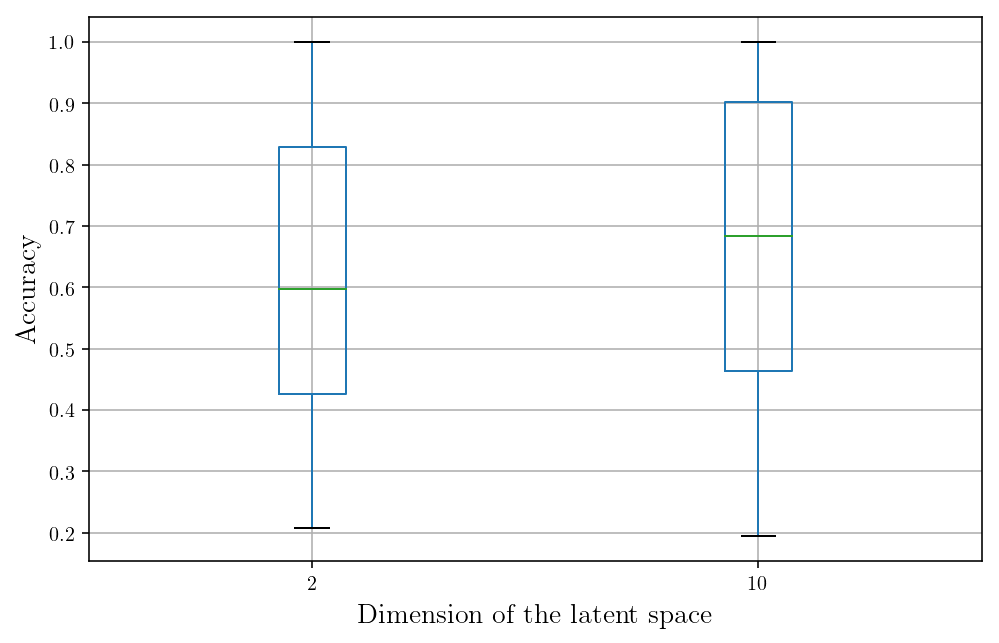

In [44]:
plt.figure(figsize=(8, 5))
accuracy.boxplot()

plt.xlabel('Dimension of the latent space', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.savefig(GRAPHICS_PATH + 'accuracy-boxplots.pdf')

# Log-probability of the reconstructions

In [45]:
logprob = pd.DataFrame(columns=[2, 10], index=np.arange(len(complete_set)), dtype=np.longfloat)

iterator = tqdm(
    enumerate(zip(
        log_reconstruction, 
        complete_set, 
        log_reconstruction2
    )), 
    ascii=True, 
    ncols=100, 
    total=len(complete_set)
)

for i, (r, p, r2) in iterator:
    
    logprob.loc[i, 2] = r2[p == 1].sum()
    logprob.loc[i, 10] = r[p == 1].sum()

100%|#######################################################| 50000/50000 [00:14<00:00, 3541.46it/s]


In [46]:
logprob.describe()

,2,10
count,50000.000000,50000.000000
mean,-97.403748,-86.067389
std,53.150451,55.021237
min,-261.561798,-466.337158
25%,-142.929443,-136.128292
50%,-109.119221,-87.047226
75%,-48.441826,-31.131783
max,-7.847949,-4.734330


In [47]:
logprob.head()

,2,10
0,-120.229416,-98.112030
1,-130.787628,-116.137009
2,-135.576782,-119.820656
3,-104.994095,-120.569191
4,-101.122177,-87.073784


In [48]:
logprob.columns.names = ['hidden dim']
logprob.index.names = ['sequence ID']

Let us save this hard-earned table:

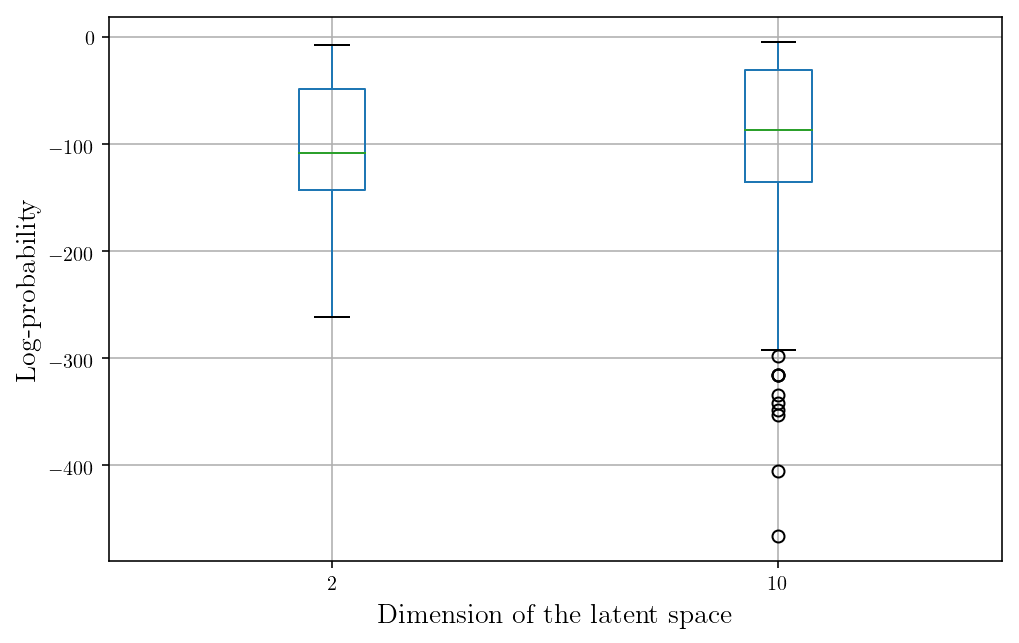

In [49]:
plt.figure(figsize=(8, 5))

logprob.boxplot()

plt.xlabel('Dimension of the latent space', fontsize=14)
plt.ylabel('Log-probability', fontsize=14)

plt.savefig(GRAPHICS_PATH + 'logprob-boxplots.pdf')

# Visualization

In [73]:
i = 27

27
Accuracy h=10 : 98.78048780487805


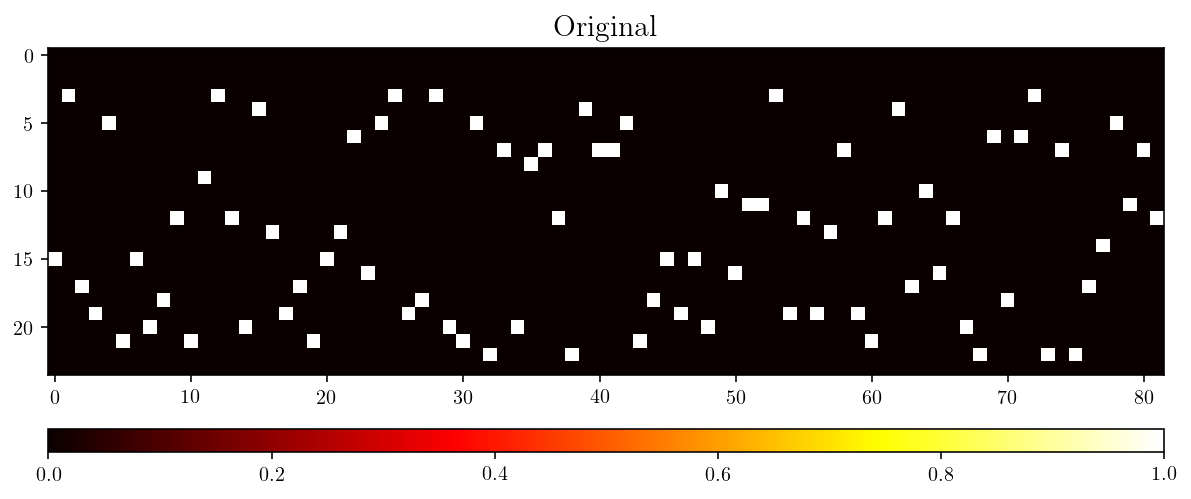

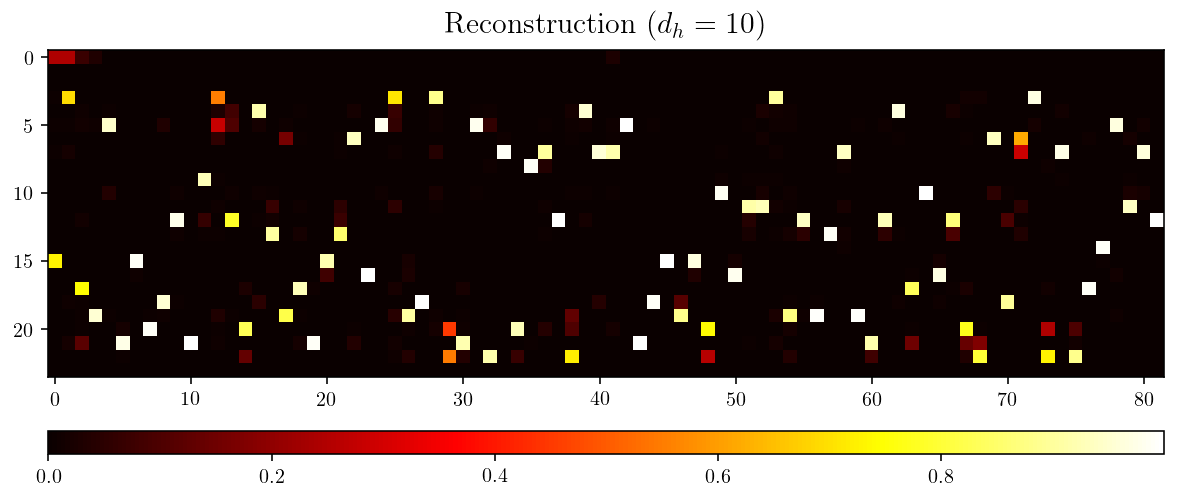

In [74]:
print(i)

prot = visualization.Protein(complete_set[i])
recon = visualization.Protein(reconstruction[i])

acc = (recon.array.argmax(axis=0) == prot.array.argmax(axis=0)).mean() * 100

print('Accuracy h=10 : {acc}'.format(acc=acc))

prot.plot_sequence(title='Original', save=GRAPHICS_PATH+'original.pdf')
recon.plot_sequence(title='Reconstruction ($d_h = 10$)', save=GRAPHICS_PATH+'reconstruction.pdf')

# Spearman correlation

In [41]:
with torch.no_grad():
    test_log_reconstruction = np.array(model.log_softmax(torch.Tensor(test_set)))

In [42]:
test_logprob = np.array([r[t == 1].sum() for r, t in zip(test_log_reconstruction, test_set)])

In [43]:
test_logprob

array([ -98.11203, -101.95644, -110.55022, ..., -101.14288,  -94.89933,
        -99.35787], dtype=float32)

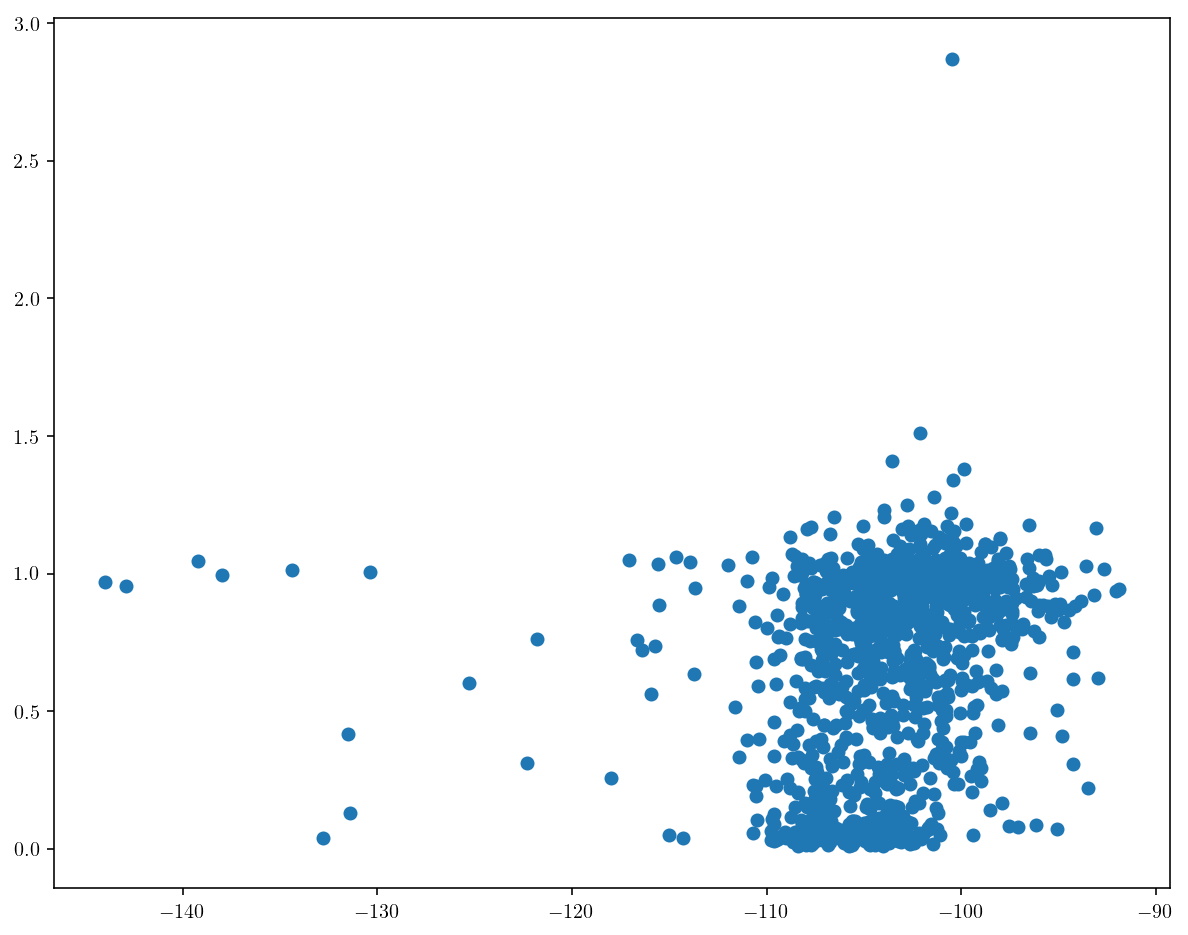

In [45]:
plt.figure(figsize=(10, 8))

plt.scatter(test_logprob, test_fitness)

In [46]:
spearmanr(test_logprob, test_fitness)

SpearmanrResult(correlation=0.31127998811268554, pvalue=4.39883508098587e-28)